In [14]:
import fitz 
import numpy as np
from PIL import Image
import cv2
from tqdm.notebook import tqdm 
import io

In [35]:
import cv2
import numpy as np
from scipy import ndimage
import imutils

def find_page_contour(img, margin=20):
    # 1. Apply gray scale
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2. Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 21, 10
    )

    # 3. Optional: morphological operations
    kernel = np.ones((3,3), np.uint8)
    processed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 4. Find contours
    cnts = cv2.findContours(processed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]  # Handle OpenCV version difference

    height, width = image.shape[:2]
    image_area = width * height
    screenCnt = None
    for c in cnts:
        area = cv2.contourArea(c)
        # Отбрасываем слишком маленькие контуры
        if area < image_area * 0.1:  # <10% от площади изображения
            continue
        
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            break
    # show the contour (outline) of the piece of paper
    print("STEP 2: Find contours of paper")
    print(screenCnt)
    output = image.copy()
    cv2.drawContours(output, [screenCnt], -1, (0, 255, 0), 2)
    cv2.imshow("Outline", output)
    cv2.waitKey(5000)
    cv2.destroyAllWindows()
    return np.array(screenCnt)
    # # 6. Корректируем контур с учетом margin
    # rect = cv2.minAreaRect(page_contour)
    # box = cv2.boxPoints(rect)
    # box = np.int32(box)
    
    # # Добавляем отступ от краев
    # center = np.mean(box, axis=0)
    # adjusted_box = []
    # for point in box:
    #     direction = point - center
    #     length = np.linalg.norm(direction)
    #     if length > 0:
    #         direction = direction / length
    #         new_point = point + direction * margin
    #         adjusted_box.append(new_point)
    
def align_document(image, max_angle=10):
    """Полный процесс выравнивания документа"""
    # 1. Пытаемся найти контур страницы
    contour = find_page_contour(image)
    print(contour)
    if contour is not None:
        try:
            # 2. Если нашли - выравниваем по контуру
            aligned = four_point_transform(image, contour.reshape(4, 2))
            return aligned
        except:
            pass
    
    # 3. Если контур не найден или выравнивание не удалось - пробуем определить угол текста
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # angle = determine_skew_angle_improved(gray, max_angle=max_angle)
    
    # if abs(angle) > 0.5:
        # return rotate_image(image, angle)
    
    return image

def four_point_transform(image, pts):
    """Точное перспективное преобразование по 4 точкам"""
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # Вычисляем ширину новой изображения
    width_a = np.linalg.norm(br - bl)
    width_b = np.linalg.norm(tr - tl)
    max_width = max(int(width_a), int(width_b))
    
    # Вычисляем высоту новой изображения
    height_a = np.linalg.norm(tr - br)
    height_b = np.linalg.norm(tl - bl)
    max_height = max(int(height_a), int(height_b))
    
    # Точки назначения
    dst = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]], dtype="float32")
    
    # Перспективное преобразование
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(
        image, M, (max_width, max_height),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(255, 255, 255)
    )
    return warped

def order_points(pts):
    """Упорядочивание точек: верх-лев, верх-прав, низ-прав, низ-лев"""
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    
    return rect

def determine_skew_angle_improved(gray, max_angle=10):
    """Улучшенное определение угла наклона текста"""
    # 1. Улучшенная бинаризация
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 21, 10
    )
    
    # 2. Удаление мелких объектов
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # 3. Использование детектора границ
    edges = cv2.Canny(cleaned, 50, 150, apertureSize=3)
    
    # 4. Поиск линий с улучшенными параметрами
    lines = cv2.HoughLinesP(
        edges, 1, np.pi/180, 100,
        minLineLength=100, maxLineGap=10
    )
    
    if lines is None:
        return 0
    
    # 5. Сбор и анализ углов
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        if abs(angle) < max_angle:  # Фильтрация по максимальному углу
            angles.append(angle)
    
    if not angles:
        return 0
    
    # 6. Медианный фильтр для устранения выбросов
    median_angle = np.median(angles)
    
    # 7. Дополнительная фильтрация (удаляем значения, сильно отличающиеся от медианы)
    filtered_angles = [a for a in angles if abs(a - median_angle) < 5]
    
    if not filtered_angles:
        return median_angle
    
    return np.mean(filtered_angles)

def rotate_image(image, angle):
    """Улучшенный поворот изображения"""
    if angle == 0:
        return image
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Вычисляем матрицу поворота
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Вычисляем новые границы изображения
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    
    # Корректируем матрицу поворота
    M[0, 2] += (new_w - w) / 2
    M[1, 2] += (new_h - h) / 2
    
    # Поворачиваем с белым фоном
    rotated = cv2.warpAffine(
        image, M, (new_w, new_h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(255, 255, 255)
    )
    
    return rotated

In [40]:
# import imutils


name = "kr3"
image = cv2.imread(f"data/{name}.jpg")

enchanced_img = find_page_contour(image)
enchanced_img

STEP 2: Find contours of paper
None


array(None, dtype=object)

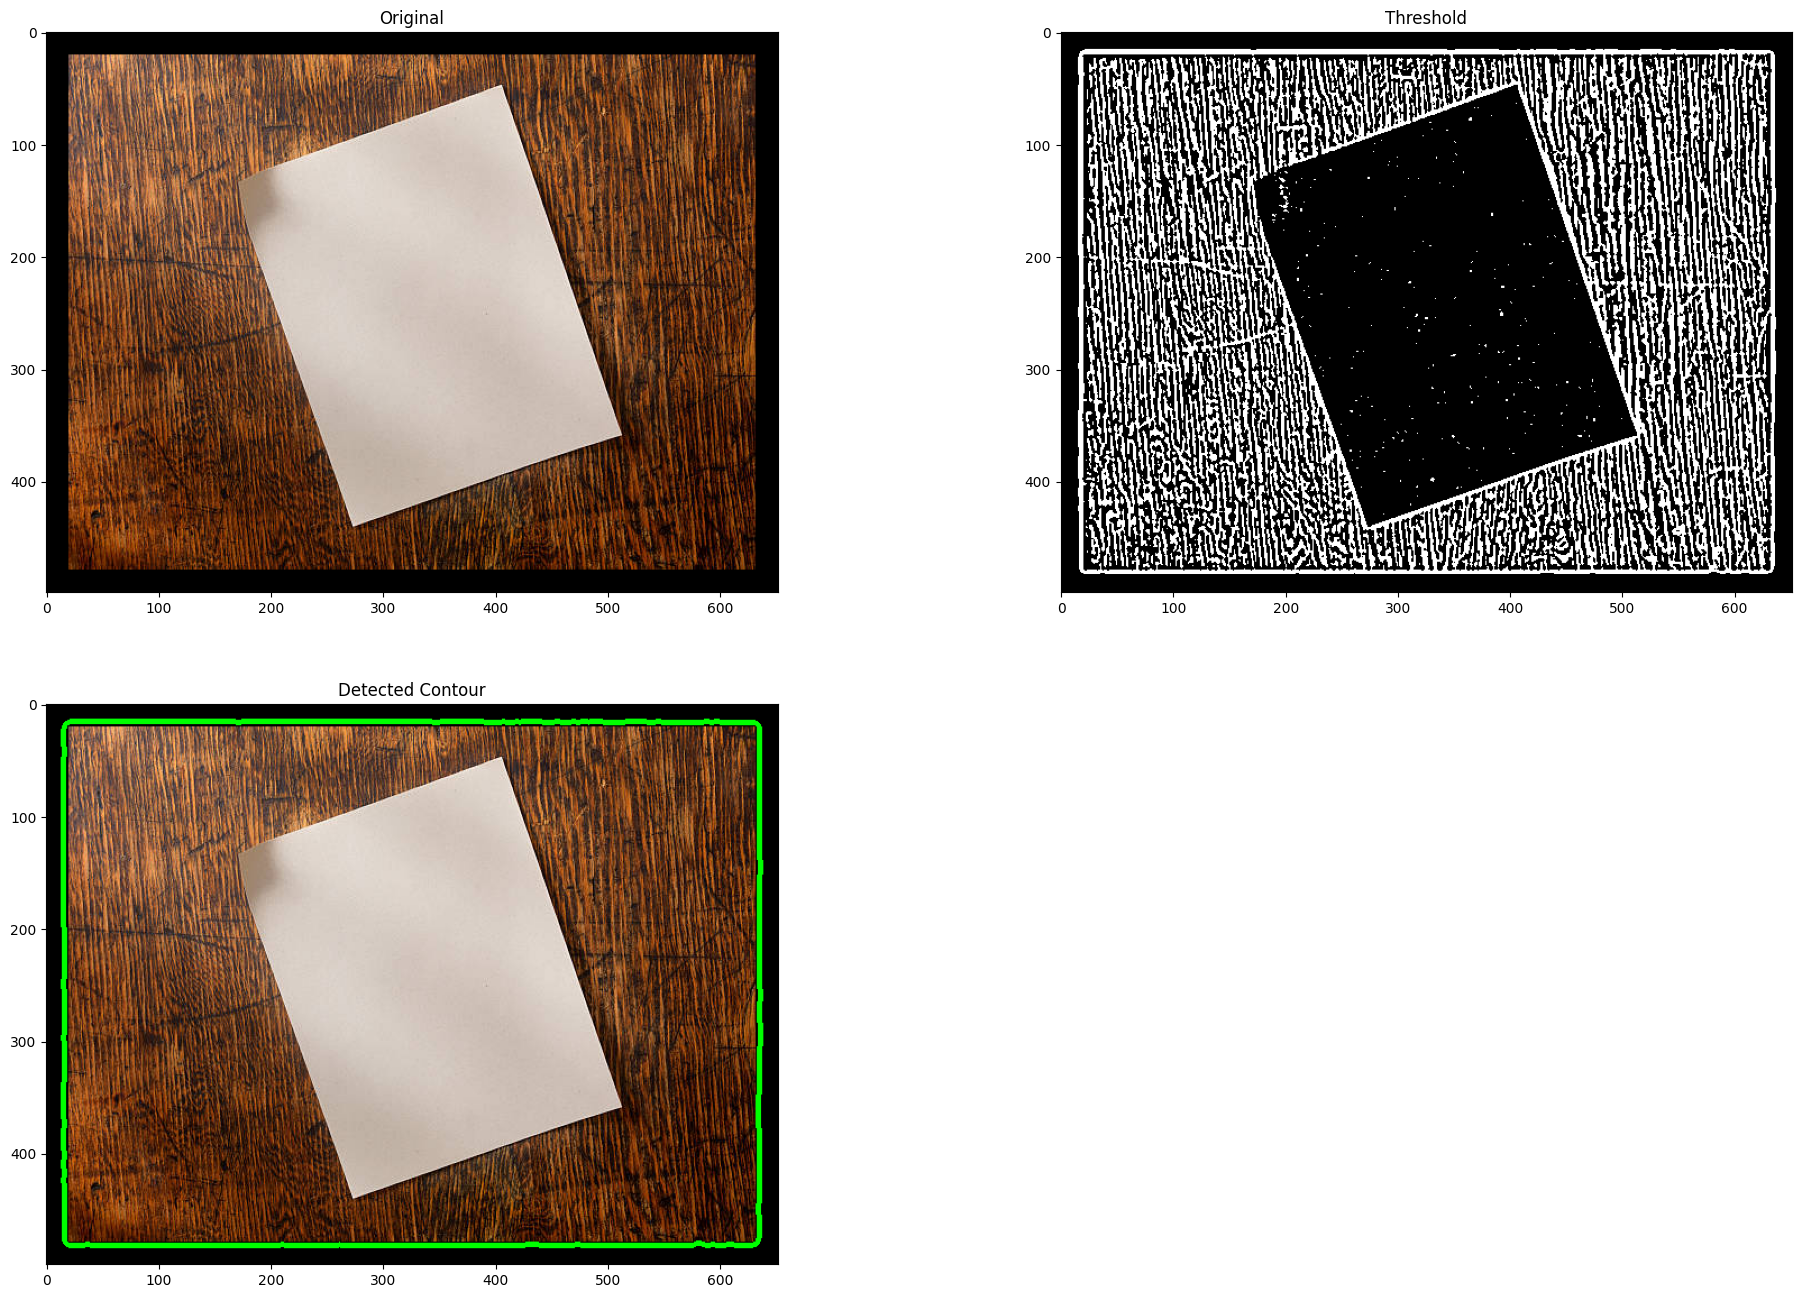

Документ успешно выровнен и сохранен как 'aligned_document.jpg'


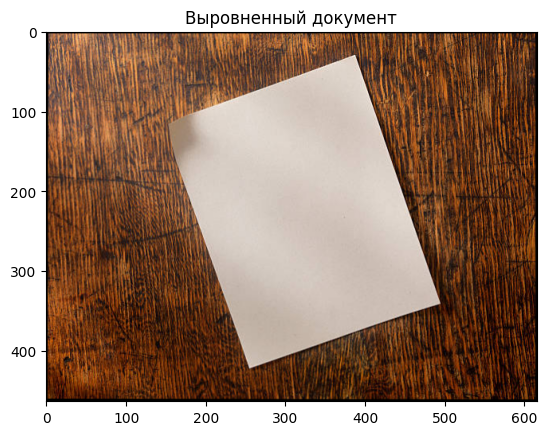

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_paper_contour(image_path, visualize=False):
    # Загрузка изображения
    image = cv2.imread(image_path)
    image = add_black_border(image)
    if image is None:
        raise ValueError("Не удалось загрузить изображение")
    
    # Сохраняем копию оригинального изображения
    original = image.copy()
    
    # Преобразование в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Уменьшение шумов с помощью Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Применение адаптивного порогового преобразования
    thresh = cv2.adaptiveThreshold(
        blurred, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 
        11, 
        2
    )
    
    # Поиск контуров
    contours, _ = cv2.findContours(
        thresh, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Сортируем контуры по площади (по убыванию) и берем 5 самых больших
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
    
    paper_contour = None
    
    
    height, width = image.shape[:2]
    image_area = width * height
    
    # Перебираем контуры в поисках прямоугольника
    for contour in contours:
        
        if cv2.contourArea(contour) < image_area * 0.1:
            continue
        
        # Аппроксимируем контур
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        
        # Если у контура 4 точки, то это вероятно прямоугольник
        if len(approx) == 4:
            paper_contour = approx
            break
    
    if visualize:
        # Визуализация для отладки
        debug_image = original.copy()
        cv2.drawContours(debug_image, contours, -1, (0, 255, 0), 3)
        
        plt.figure(figsize=(24, 16))
        plt.subplot(221), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)), plt.title('Original')
        plt.subplot(222), plt.imshow(thresh, cmap='gray'), plt.title('Threshold')
        plt.subplot(223), plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB)), plt.title('Detected Contour')
        plt.show()
    
    return paper_contour, original

def align_paper(image, contour):
    # Упорядочиваем точки контура в порядке: верх-лево, верх-право, низ-право, низ-лево
    rect = order_points(contour.reshape(4, 2))
    (tl, tr, br, bl) = rect
    
    # Вычисляем ширину нового изображения
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # Вычисляем высоту нового изображения
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # Создаем массив точек для перспективного преобразования
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    # Применяем перспективное преобразование
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

def order_points(pts):
    # Инициализируем список координат, который будет упорядочен
    # в порядке: верх-лево, верх-право, низ-право, низ-лево
    rect = np.zeros((4, 2), dtype="float32")
    
    # Верх-левая точка будет иметь наименьшую сумму,
    # а низ-правая - наибольшую
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # Теперь вычислим разницу между точками
    # Верх-правая точка будет иметь минимальную разницу
    # а низ-левая - максимальную
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def add_black_border(image, border_size=20):
    """Adds a black border around the image"""
    return cv2.copyMakeBorder(
        image,
        top=border_size,
        bottom=border_size,
        left=border_size,
        right=border_size,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # Black color
    )

# Пример использования
if __name__ == "__main__":
    image_path = "data/paper.jpg"
    
    try:
        # Находим контур листа
        contour, image = find_paper_contour(image_path, visualize=True)
        
        if contour is not None:
            # Выравниваем лист
            aligned = align_paper(image, contour)
            
            # Сохраняем результат
            cv2.imwrite("aligned_document.jpg", aligned)
            print("Документ успешно выровнен и сохранен как 'aligned_document.jpg'")
            
            # Показать результат
            plt.imshow(cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB))
            plt.title("Выровненный документ")
            plt.show()
        else:
            print("Не удалось найти контур листа бумаги")
    except Exception as e:
        print(f"Произошла ошибка: {e}")